## Introduction to machine learning techniques
## Examplar Exercises using using scikit-learn with the Hillenbrand database

In [ ]:
# setup the imports for Python's baseline machine learning stack 
# This requires  
#          numpy & pandas for data manipulation and computations
#          matplotlib and seaborn for plotting
% matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import scipy.io as sio
import io as spchio
# imports from the scikit-learn 
from sklearn.datasets.base import Bunch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture




In [ ]:
# special imports for this exercise
# 
#exercise_dir = 'C:\\Users\\compi\\Nextcloud\\Jupyter\\lab sessions\\Hillenbrand'
#os.chdir(exercise_dir)
print(os.getcwd())
from hildata import fetch_hillenbrand
# help(fetch_hillenbrand)

## Hillenbrand Database 
All experiments in this notebook are using (parts of) the Hillenbrand 95 database. Click for detailed information and references(http://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt)

The function fetch_hillenbrand() fetches the database in a similar way as the databases supported by sklearn.
There are arguments to make a subselection of the database
 - gender
 - vowel
 - features 
Also a subset selection of targets can be specified

The output is by default provided in a Bunch object with contents:
- data: raw data for selected features
- target: classification labels (possibly multi-class)
- target_names
- feature_names


In [ ]:
# By default fetch_hillenbrand returns {f0,F1,F2,F3] as features and
# [gid, vid] as targets
hillenbrand = fetch_hillenbrand()
print('Features: ',hillenbrand.feature_names)
print('Targets: ',hillenbrand.target_names)
print('Data:\n ',hillenbrand.data)
# for a nicer viualization of all data we have
#for id,dat in zip(hil.target,hil.data):
#    print(id,dat)

# also define a simple make_selection routine that allows for further (column) selecction in 
# view of an experiment
def make_selection(dataset,feature_list=['f0'],target_list=['gid']):
    feat_indices =  [ dataset.feature_names.index(ft) for ft in feature_list ]
    target_indices =  [ dataset.target_names.index(t) for t in target_list ]
    X = dataset.data[:,feat_indices]
    y = dataset.target[:,target_indices]
    return(X,y)

### EXPERIMENT 1:  GENDER from PITCH

In this experiment we try to classify speakers according to gender, given average pitch over a singl vowel segment

- features(X): 'f0', a continuous 1-D feature
- targets(y): 'gid', 2 classes: 'm' and 'w'  

In [ ]:
X,y = make_selection(hillenbrand,feature_list=['f0'],target_list=['gid'])
# print(X,y)

### 1.1  Data Analysis of the unlabeled data -- Fitting with Gaussian Mixture Models
A popular method for fitting unknown densities is the usage fo Gaussian Mixture Models.  Sometimes the multiclass nature of the data will show up as a clear multimodal fit to the data.
In such cases the GMM fit can be used to discover the individual classes and GMMs can be used for clustering. If the number of gaussians does not match the number of classes or if the multimodal nature is not sufficiently pronounced then a blind clustering procedure with GMMs will yield a fuzzy result.
So the procedure only works well if classes are rather well separated and the number of classes is known in advance.

In our case (f0 data of a mixed male/female) we can expect 2 clusters with quite well separated distributions that are more or less Gaussian on top of that.
To further investigate the above we make fits to the data with 1,2,3 and 4 mixtures.

We make use of the *GaussianMixture()* module in the **sklearn** package.

#### Questions
1. In which cases do we see underfitting or overfitting
2. In which cases do the individual means of the distributions give you common sense information about the distribution of either class
3. If you like to see what happens, with larger number of Gaussians, change the parameter max_gaussians = ... to a different number

### Answerw & Conclusions
1. It is quite obvious that the 1-mixture fit yields a gross underfitting of the data.   The 3 and 4 mixture fits give additional information that is hard to interpret and it is probably nothing more than exhibition of overfitting. 
2. As expected the 2-mixture fit captures the  bimodal distribution very well.  Only in this case we may find rather expected mean values for pitch of male and female, respectively 130Hz and 220Hz


ng=1:   [[177.24820789]]
ng=2:   [[130.30136855 220.82568753]]
ng=3:   [[150.68419319 222.0678659  119.23384176]]
ng=4:   [[148.0358162  236.27991305 116.95364025 210.293673  ]]


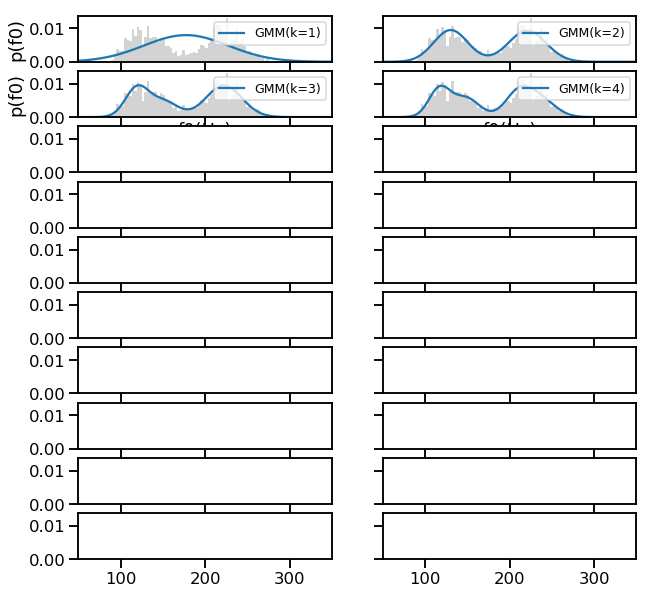

In [22]:
#from sklearn.mixture import GaussianMixture
max_gaussians = 4
nrows = int((max_number_of_gaussians+1)/2)
xmin = np.min(X)
xmax = np.max(X)
xx = (xmax-xmin)/20
xmin = 50*np.fix((xmin-25)/50)
xmax = 50*np.round((xmax+25)/50)
xp = np.linspace(xmin,xmax,100)
# you need to do this reshaping as it expects 2D data with shape (n_samples,n_features)
xp = xp.reshape(-1,1)
    
plt.close('all')
fig, ax = plt.subplots(nrows,2, sharex=True, sharey=True, figsize=(10,10))
for i in range(0,max_gaussians) :
    ncomp = i+1
    gmm = GaussianMixture(max_iter=10,random_state=1,n_components=ncomp,init_params='kmeans')
    gmm.fit(X,y)
    print("ng=%d:  " % ncomp,gmm.means_.T)
    yp = gmm.score_samples(xp)
    ii = int(i/2); jj=i%2
    ax[ii,jj].hist(X,bins=100,range=(xmin,xmax),density=True,color='lightgrey')
    ax[ii,jj].plot(xp,np.exp(yp),label='GMM(k=%d)' % ncomp)
    ax[ii,jj].set_xlim(xmin,xmax)
    if jj == 0:
        ax[ii,jj].set_ylabel('p(f0)')
    if ii == 1:
        ax[ii,jj].set_xlabel('f0(Hz)')
    ax[ii,jj].legend(loc='upper right',fontsize='x-small')

plt.show()

####  Data Analysis - Getting to know the data

A first step in all data science is getting to know the data.   
The most common way is to look at histograms and scatter plots.
The plot below shows a simple 2 class histogram 

As simple as it may look, there are some aspects that should be dealt with with care.
We will explore two such things:  the number of bins in the histogram and the scaling of
the feature axis

#### INVESTIGATE:
1. The principle parameter that needs adjustment is the 'n_bins' parameter.  It sets the number of bins in a histogram.  Explain how n_bins is related to the size of your database, the number of classes and/or the dimensionality of the feature vectors ?
2. We commonly express pitch in physical units 'Hz'.  However, it is equally common to express pitch on a musical scale.  E.g. in Western music an octave is divided into 12 equal parts on a logartihmic scale, also called {\bf semitones}. Important to note is that such musical scale, just as any other logarithmic scale, is a relative scale.  
logarithmic scalerelative to the average pitch  used to express Modify your observations from Hz to logHz by applying np.log() to the features
     What does this tell about intrisic variability of male vs. female voices

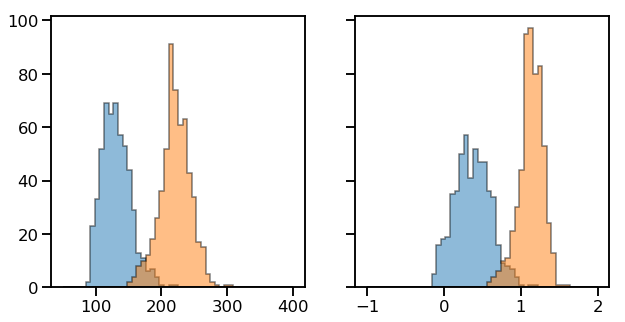

In [23]:
plt.close('all')
def freq2st(f,base=100.):
    return np.log2(f/base)
n_bins = 50
f0_range = np.asarray([50., 400.])
#
x1 = X[y=="m"]
x2 = X[y=="w"]
kwargs = dict(histtype='stepfilled', alpha=.5, bins=n_bins, density=False, ec="k")
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax1.hist(x1, **kwargs,range=f0_range)
ax1.hist(x2, **kwargs,range=f0_range)
ax2.hist(freq2st(x1), **kwargs, range=freq2st(f0_range))
ax2.hist(freq2st(x2), **kwargs, range=freq2st(f0_range))
plt.show()

### Exp 1.3 Gender Recognition using Gaussian Fits and a Bayesian classifier

1. split the data in 50% for training and 50% for test
    -  X_train, y_train, X_test, y_test
2. fit a single Gaussian model to each class based on the training data
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data


In [24]:


classes = ['m','w']
targets = ['gid']
features = ['f0']
vowels = []
# example usage with a panda dataframe on return
hildf.sid.unique()
hildf = load_hillenbrand(genders=classes,vowels=vowels,features=features,targets=['sid','gid','vid'],Output='DataFrame')    

NameError: name 'hildf' is not defined

In [25]:
classes = ['m','w']
targets = ['gid']
features = ['f0']
vowels = []
hil = load_hillenbrand(genders=classes,vowels=vowels,features=features,targets=targets)
X=hil.data
# y must be an array of shape [nsamples] and X an array of shape [nsamples, nfeatures]
y=hil.target[:,0]
#print(type(y),y.shape,type(X),X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=0)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#type(X_train), type(y_train)

NameError: name 'load_hillenbrand' is not defined

In [ ]:
ncomp = 1
nclass = len(classes)
nsamples = len(y_train)
print(classes,type(classes))
print(type(X_train),X_train.shape)

gmm = [GaussianMixture(max_iter=10,random_state=1,n_components=ncomp, 
                        init_params='kmeans') for k in range(0,nclass)]


for k in range(0,nclass) :
    ksel = [y_train[i] == classes[k] for i in range(nsamples)]
    XX = X_train[ksel,:]
    print(XX.shape)
    gmm[k].fit(X_train[ksel],y_train[ksel])
    print(gmm[k].means_,np.sqrt(gmm[k].covariances_))


In [ ]:
from skspeech.gmmclassifier import gmmclassifier
#help(gclass)
gmclass = gmmclassifier(n_classes=2)
gmclass.fit(X_train,y_train)
gmclass.print()

#for k in range(0,2):
#        print(gmclass.gmm[k].weights_,gmclass.gmm[k].means_,
#              np.sqrt(gmclass.gmm[k].covariances_))

In [ ]:
L,T = gmclass.predict_prob(X_test[0:8,:])
L,T

In [ ]:
print(y_test,type(y_test),y_test.dtype)

In [ ]:
# compute likelihood and posteriors for test dataset
nsamples = len(X_test)
x_lik = np.zeros(nsamples)
x_class_lik = np.zeros((nsamples,nclass))
x_class_post = np.zeros((nsamples,nclass))
for k in range(0,nclass):
    x_class_lik[:,k] =np.exp( gmm[k].score_samples(X_test) )
    x_lik = x_lik + x_class_lik[:,k]
for k in range(0,nclass):
    x_class_post[:,k] = x_class_lik[:,k] / x_lik
    
y_true = np.array(['m']*nsamples)

war = x_class_post[:,1] > x_class_post[:,0]
print(war)

for i in range(0,nsamples):
    if (war[i]):
        y_true[i] = 'w' 

for y,yt in zip(y_test,y_true):
    print(y,yt)
    
for x,y,yt in zip(x_class_post,y_test,y_true):
    if y != yt:
        print(x,y,yt)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print(sc.mean_, sc.var_)
X_train_std = X_train -177
X_test_std = X_test - 177

In [ ]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40, tol=0.01, random_state=0)
ppn.fit(X_train_std, y_train)
print(ppn.classes_,ppn.n_iter_)
print(ppn.coef_,ppn.intercept_)


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = ppn.predict(X_test_std)
#print(y_pred,y_test)
y_pred = ppn.predict(X_test_std)
errorindx = (y_test != y_pred)
errorindx,errorindx.sum()
#print('Misclassified samples:  ', errorindx)

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

At this point Xpd and Ypd are panda DataFrame and a panda Series (1D DataFrame).  In the next experiment we show simple operations with sklearn, so we first convert these panda DataStructures to numpy arrays

In [ ]:
X = Xpd.as_matrix()
y = ypd.as_matrix()
X, y

Split dataset into 50% for training and 50% for testing

In [ ]:
features = ['gid','vid','f0','F1','F2']
data=hildata.loc[:,features].copy()
grouped=data.groupby(['gid','vid'],as_index=False)
#grouped.get_group(('m','ae')).mean()
#grouped
grouped.agg([np.mean, np.std])
#print(subdata)

In [ ]:
m_indx = Y=='m'
w_indx = Y=='w'
N_m = sum(m_indx)
N_w = sum(w_indx)
mu_m = X[m_indx].mean()
mu_w = X[w_indx].mean()
N_m, mu_m, N_w, mu_w
# print('m(',N_m,')=',mu_m)
# mu_m.info()



In [ ]:
fig, ax = plt.subplots()
n=bins = ax.hist(X,100,density=1)
plt.show()

In [ ]:
m_mu = data.query('gid=="m"').mean()
w_mu = data.query('gid=="w"').mean()
# m_mu.dtypes, m_mu.shape, m_mu, m_mu.index

Example of how to concatenate multiple series of results into one larger dataframe.  The 'keys' let you override the columnlabels.
This is quite useful for presenting results.